# Attempt Number 10

## Read in data, view it and split into training set and test set

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np

In [2]:
#Read CSV file into a Pandas DataFrame object
raw_data = pd.read_csv("tcd ml 2019-20 income prediction training (with labels).csv")

In [3]:
raw_data.shape

(111993, 12)

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111993 entries, 0 to 111992
Data columns (total 12 columns):
Instance             111993 non-null int64
Year of Record       111552 non-null float64
Gender               104561 non-null object
Age                  111499 non-null float64
Country              111993 non-null object
Size of City         111993 non-null int64
Profession           111671 non-null object
University Degree    104623 non-null object
Wears Glasses        111993 non-null int64
Hair Color           104751 non-null object
Body Height [cm]     111993 non-null int64
Income in EUR        111993 non-null float64
dtypes: float64(3), int64(4), object(5)
memory usage: 10.3+ MB


In [5]:
raw_data.head()

,Instance,Year of Record,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income in EUR
0,1,1997.0,0,41.0,Belarus,1239930,steel workers,Bachelor,0,Blond,193,61031.94416
1,2,1996.0,other,41.0,Singapore,1603504,safe event coordinator,Master,0,Black,186,91001.32764
2,3,2018.0,other,28.0,Norway,1298017,receivables/payables analyst,PhD,1,Brown,170,157982.17670
3,4,2006.0,other,33.0,Cuba,751903,fleet assistant,No,1,Black,171,45993.75793
4,5,2010.0,female,46.0,United Arab Emirates,95389,lead trainer,0,0,Blond,188,38022.16217


In [6]:
#Split data into a training set and a test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(raw_data, test_size=0.2, random_state=37)

In [7]:
#Print details of training and test sets
print("train_set type is: ", type(train_set))
print("train_set shape is: ", train_set.shape)
print("test_set type is: ", type(test_set))
print("test_set shape is: ", test_set.shape)

train_set type is:  <class 'pandas.core.frame.DataFrame'>
train_set shape is:  (89594, 12)
test_set type is:  <class 'pandas.core.frame.DataFrame'>
test_set shape is:  (22399, 12)


## Explore Data

In [8]:
#Make a copy of train_set before we start manipulating it
data = train_set.copy()

In [9]:
#examine correlations between attributes and incomes
corr_matrix = data.corr()
corr_matrix["Income in EUR"].sort_values(ascending =False)

Income in EUR       1.000000
Age                 0.184292
Year of Record      0.165505
Body Height [cm]    0.072744
Size of City        0.016052
Wears Glasses       0.004488
Instance            0.004118
Name: Income in EUR, dtype: float64

In [10]:
#drop (possibly) unnecesary colums based on correlation matrix
data = data.drop(["Instance", "Wears Glasses"], axis = 1)

### look at some plots of the data

In [11]:
import seaborn as sns

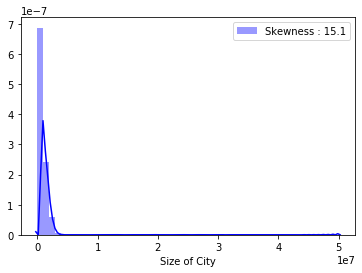

In [12]:
#plot size of city
plot1 = sns.distplot(data["Size of City"], color="b", label="Skewness : %.1f"%(data["Size of City"].skew()))
plot1 = plot1.legend(loc="best")

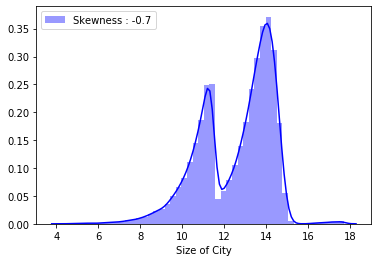

In [13]:
#plot log size of city
data["Size of City"] = np.log(data["Size of City"])
plot2 = sns.distplot(data["Size of City"], color="b", label="Skewness : %.1f"%(data["Size of City"].skew()))
plot2 = plot2.legend(loc="best")

#### The original "Size of City" data is quite skewed. After taking logs it has an unusual shape -> suggests it's irrelevant?

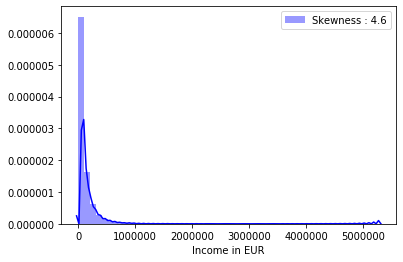

In [14]:
#plot "Income in Euro", i.e. the labels
plot3 = sns.distplot(data["Income in EUR"], color="b", label="Skewness : %.1f"%(data["Income in EUR"].skew()))
plot3 = plot3.legend(loc="best")

C:\Users\donal\Anaconda3\envs\machine_learning\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


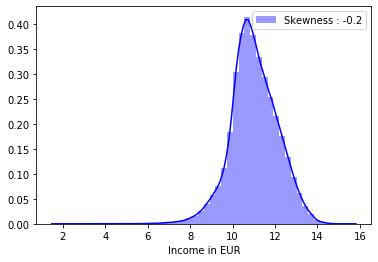

In [15]:
#plot logs of "Income in EUR"
data["Income in EUR"].transform(np.absolute, axis = 0)
data["Income in EUR"] = np.log(data["Income in EUR"])
data = data.dropna(subset = ["Income in EUR"])
plot4 = sns.distplot(data["Income in EUR"], color="b", label="Skewness : %.1f"%(data["Income in EUR"].skew()))
plot4 = plot4.legend(loc="best")

#### the incomes, i.e. labels are quite skewed. This suggests I should use the log incomes as my labels, predict log incomes and then take the exponentials of my predictions?

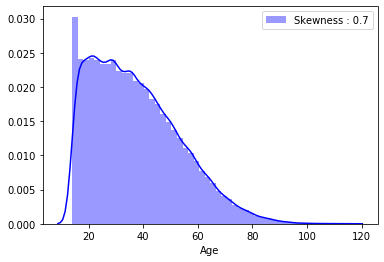

In [16]:
#plot "Age"
data = data.dropna(subset = ["Age"])
plot5 = sns.distplot(data["Age"], color="b", label="Skewness : %.1f"%(data["Age"].skew()))
plot5 = plot5.legend(loc="best")

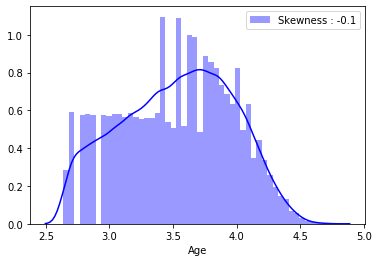

In [17]:
data["Age"] = np.log(data["Age"])
plot6 = sns.distplot(data["Age"], color="b", label="Skewness : %.1f"%(data["Age"].skew()))
plot6 = plot6.legend(loc="best")

#### The age data doesn't seem too skewed and there isn't much improvement from taking logs <- leave as is

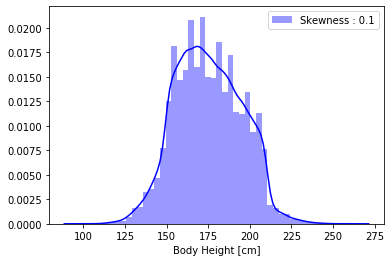

In [18]:
#plot "Body Height [cm]"
plot7 = sns.distplot(data["Body Height [cm]"], color="b", label="Skewness : %.1f"%(data["Body Height [cm]"].skew()))
plot7 = plot7.legend(loc="best")

#### The body height data isn't skewed <- leave as is

### look at some of the categorical data

In [19]:
#look at categories for gender
data["Gender"].value_counts()

male       34062
female     21633
other      21477
unknown     5476
0            583
Name: Gender, dtype: int64

#### combine 0's and missing values with unknown?

In [20]:
data["University Degree"].value_counts()

Bachelor    34345
No          21472
Master      21394
PhD          5421
0             566
Name: University Degree, dtype: int64

#### combine 0's and missing values with no?

## Build Model

### Define data transformations

In [57]:
#Take a clean copy of the data and separate the labels
X_train = train_set.drop(['Income in EUR'], axis=1)
y_train = train_set["Income in EUR"].copy()

In [58]:
#cap salaries at 1,800,000
y_train.clip(upper = 1800000, inplace = True)

In [59]:
y_train.describe()

count    8.959400e+04
mean     1.091927e+05
std      1.481711e+05
min     -4.912846e+03
25%      3.075598e+04
50%      5.744297e+04
75%      1.260499e+05
max      1.800000e+06
Name: Income in EUR, dtype: float64

#### Construct Transformation Pipeline

In [60]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import Pipeline

In [61]:
#fill missing numerical data with medians and apply MaxAbs scaling <-need to experiment if this is best scaling
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy = "median")),
    ('std_scaler', MaxAbsScaler())
])

In [62]:
#Use this pipeleing for profession and country
#fill missing values with unknown
#apply one hot encoding
cat1_pipeline = Pipeline([
    ('imputer1', SimpleImputer(strategy = "constant", fill_value = "unknown" )),
    ('1HotEnc1', OneHotEncoder(handle_unknown='ignore'))
])

In [63]:
#use this pipeline for gender
#combine missing values and 0's with unknowns
#one hot encoding
catGen_pipeline = Pipeline([
    ('imputerGen1', SimpleImputer(strategy = "constant", fill_value = "unknown" )),
    ('imputerGen2', SimpleImputer(missing_values = '0', strategy = "constant", fill_value = "unknown" )),
    ('1HotEnc1', OneHotEncoder())
])

In [64]:
#use this pipeline for university degree
#combine missing values and 0's with 'No'
#one hot encoding
catUni_pipeline = Pipeline([
    ('imputerUni1', SimpleImputer(strategy = "constant", fill_value = "No" )),
    ('imputerUni2', SimpleImputer(missing_values = '0', strategy = "constant", fill_value = "No" )),
    ('1HotEnc1', OneHotEncoder())
])

##### Final single transformer to handle all columns

In [65]:
from sklearn.compose import ColumnTransformer

In [66]:
#Drop "Instance", "Size of City", "Hair Color" and "Wears Glasses"
num_attribs = ["Year of Record", "Age", "Body Height [cm]"]
cat_attribs = ["Profession", "Country"]

In [67]:
#combine above pipelines for form final pipeline
full_pipeline = ColumnTransformer([  
    ("num", num_pipeline, num_attribs),
    ("cat", cat1_pipeline, cat_attribs),
    ("catGen", catGen_pipeline, ["Gender"]),
    ("catEd", catUni_pipeline, ["University Degree"])
])

In [68]:
#transform data using above defined pipelne
X_train_prepared = full_pipeline.fit_transform(X_train)

### Pick and Train Model

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

In [70]:
#Basic model is linear regression
lin_reg = LinearRegression()

In [71]:
#But I will train my model using log incomes, then predict log incomes and finally take the exponential of my predictions
def func(x):
    return np.log(np.absolute(x))
def inv_func(x):
    return np.exp(x)

In [72]:
regr = TransformedTargetRegressor(regressor = lin_reg, func = func, inverse_func = inv_func)

In [73]:
#fit the model using the training data
regr.fit(X_train_prepared, y_train)

TransformedTargetRegressor(check_inverse=True,
                           func=<function func at 0x000001BD73A040D8>,
                           inverse_func=<function inv_func at 0x000001BD73A04438>,
                           regressor=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           transformer=None)

### Test model on a small sample of training set

In [74]:
#look at first five instances to get an idea of how model performs
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", regr.predict(some_data_prepared))

Predictions: [101373.95176724 114757.52744916  87497.11001805  16988.17220856
  18561.31963102]


In [75]:
print("Labels:", list(some_labels))

Labels: [170325.6465, 110902.4132, 65849.02593999999, 38821.986039999996, 25035.59966]


### Calculate RMSE for training set

In [76]:
from sklearn.metrics import mean_squared_error

In [77]:
train_predictions = regr.predict(X_train_prepared)

In [78]:
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)

In [79]:
train_rmse

53057.53756655624

### Perform Cross-Validation

In [80]:
from sklearn.model_selection import cross_val_score

In [81]:
lin_scores = cross_val_score(regr, X_train_prepared, y_train, scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [82]:
def display_scores(scores):
    print("Scores: ",  scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

In [83]:
display_scores(lin_rmse_scores)

Scores:  [58383.84578563 55475.81735049 52810.1730637  55107.84705526
 51428.31445763 56882.6370551  51829.59121817 53381.78360738
 57359.0918001  60892.25602037]
Mean:  55355.13574138186
Standard deviation:  2906.5089826997773


### Check Model with test_set

In [84]:
X_test = test_set.drop("Income in EUR", axis=1)
y_test = test_set["Income in EUR"].copy()

In [85]:
y_test.describe()

count    2.239900e+04
mean     1.087346e+05
std      1.471318e+05
min     -5.696906e+03
25%      3.085402e+04
50%      5.694741e+04
75%      1.263153e+05
max      2.515871e+06
Name: Income in EUR, dtype: float64

In [86]:
#transform test_set data
X_test_prepared = full_pipeline.transform(X_test)

In [87]:
#make predictions for test_set
test_predictions = regr.predict(X_test_prepared)

In [88]:
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

In [89]:
#rmse for test set
test_rmse

56049.63416200877

### Make Predictions for Competition

In [ ]:
#read in competition data into a Pandas DataFrame
X_comp = pd.read_csv("tcd ml 2019-20 income prediction test (without labels).csv")

In [ ]:
X_comp.info()

In [ ]:
#Transform competition data
X_comp_prepared = full_pipeline.transform(X_comp)

In [ ]:
#Make competition predicitons
comp_predictions = regr.predict(X_comp_prepared)

In [ ]:
#Add predicitons to competition data
X_comp["Income in EUR"] = comp_predictions

In [ ]:
X_comp.head()

In [ ]:
#Make CSV file with predictions
X_comp.to_csv(r"⁨attemptX.csv")